In [ ]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brute, fmin
from scipy.interpolate import splev, splrep
import math
from scipy.stats import lognorm, norm
#from numba import jit

# To load data from google drive. Remove/сomment if run outside colab
from google.colab import drive
drive.mount('/content/drive')

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

# This is used to display results of calcibrations
from prettytable import PrettyTable

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1

# Data for calibration

In [ ]:
# Data for calibration
path = "/content/drive/MyDrive/WQU/MScFE 622_Stochastic_Modeling_GWP1_Option data_Sheet1.csv"
data = pd.read_csv(path)
S0 = 232.90
data['r'] = 0.015
data['T'] = data.apply(lambda x: x['Days to maturity']/250, axis=1) # Time to maturity in years, assuming 250 trading days/year

# Split dataset into options with 15 and 60 DtM
call_options_15_dtm = data.loc[(data['Days to maturity'] == 15) & (data['Type'] == 'C')]
put_options_15_dtm = data.loc[(data['Days to maturity'] == 15) & (data['Type'] == 'P')]
call_options_60_dtm = data.loc[(data['Days to maturity'] == 60) & (data['Type'] == 'C')]
put_options_60_dtm = data.loc[(data['Days to maturity'] == 60) & (data['Type'] == 'P')]
call_options_15_dtm.reset_index(inplace=True, drop=True)
put_options_15_dtm.reset_index(inplace=True, drop=True)
call_options_60_dtm.reset_index(inplace=True, drop=True)
put_options_60_dtm.reset_index(inplace=True, drop=True)

#Data is divided into 4 datasets: puts and calls with 15 days to maturity and with 60 days to maturity

## A - Calibrating Heston (1993) model via Lewis (2001)

## B - Calibrating Heston (1993) model via Carr and Madan (1999)

In [ ]:
def CM_Heston_opt(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, opt_type):
    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0
    if opt_type == 'C':
        return CallValue
    elif opt_type == 'P':
        return CallValue + K * np.exp(-r*T) - S0 # Modification to calculate Put option value based on put-call parity

i = 0
min_MSE = 500

def H93_error_function_cm_call(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    data = call_options_15_dtm
    for row, option in data.iterrows():
        model_value = CM_Heston_opt(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            'C'
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    #if i % 25 == 0:
    #    print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def H93_error_function_cm_put(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    data = put_options_15_dtm

    for row, option in data.iterrows():
        model_value = CM_Heston_opt(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            'P'
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    #if i % 25 == 0:
    #    print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def H93_calibration_full_CM(opt_type):
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    if opt_type == "C":
        p0 = brute(
            H93_error_function_cm_call,
        (
            (0, 15.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.551, 0.1),  # sigma_v
            (-0.75, 0.75, 0.25),  # rho
            (0.001, 0.031, 0.001),  # v0
        ),
        finish=None,
    )
        opt = fmin(
            H93_error_function_cm_call, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
        )
    elif opt_type == 'P':
      p0 = brute(
          H93_error_function_cm_put,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01), # v0
        ),  
      finish=None,
    )
      opt = fmin(
        H93_error_function_cm_put, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt


def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

In [ ]:
params_call_15_cm = H93_calibration_full_CM("C")

In [ ]:
params_put_15_cm = H93_calibration_full_CM("P")

In [ ]:
param_names = ['κᵥ', 'θᵥ', 'σᵥ', 'ρ', 'v₀']

In [ ]:
print("Model parameters for call options with 15 days to maturity (Carr and Madan apprach):")
table_call = PrettyTable(param_names)
table_call.add_row(np.round(params_call_15_cm,3))
print(table_call)

Model parameters for call options with 15 days to maturity (Carr and Madan apprach):
+-------+-------+-----+------+-------+
|   κᵥ  |   θᵥ  |  σᵥ |  ρ   |   v₀  |
+-------+-------+-----+------+-------+
| 6.703 | 0.037 | 0.7 | -1.0 | 0.001 |
+-------+-------+-----+------+-------+


In [ ]:
print("calibraion parameters for put options with 15 days to maturity (Carr and Madan apprach):")
table_put = PrettyTable(param_names)
table_put.add_row(np.round(params_put_15_cm,3))
print(table_put)

calibraion parameters for put options with 15 days to maturity (Carr and Madan apprach):
+-------+-------+-------+------+-------+
|   κᵥ  |   θᵥ  |   σᵥ  |  ρ   |   v₀  |
+-------+-------+-------+------+-------+
| 9.649 | 0.008 | 0.389 | -0.0 | 0.006 |
+-------+-------+-------+------+-------+


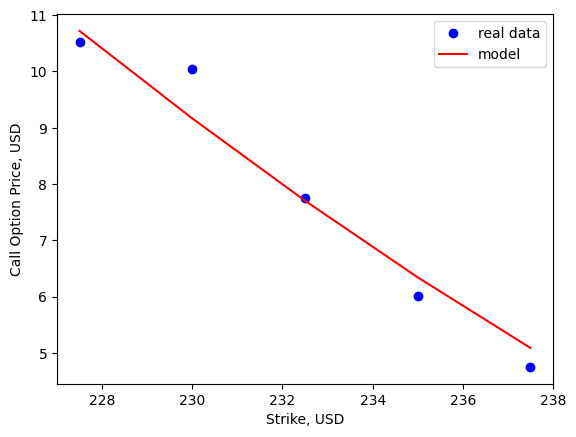

In [ ]:
model_prices = [CM_Heston_opt(S0, call_options_15_dtm['Strike'][i], call_options_15_dtm['T'][i], call_options_15_dtm['r'][i], *params_call_15_cm,'C') for i in range(len(call_options_15_dtm))]
call_options_15_dtm['model_prices'] = model_prices
y1 = call_options_15_dtm['Price']
y2 = call_options_15_dtm['model_prices']
x = call_options_15_dtm['Strike']
plt.plot(x,y1, 'bo', label = "real data")
plt.plot(x,y2, color='red',label = "model")
plt.xlabel('Strike, USD')
plt.ylabel('Call Option Price, USD')
plt.legend()
plt.show()

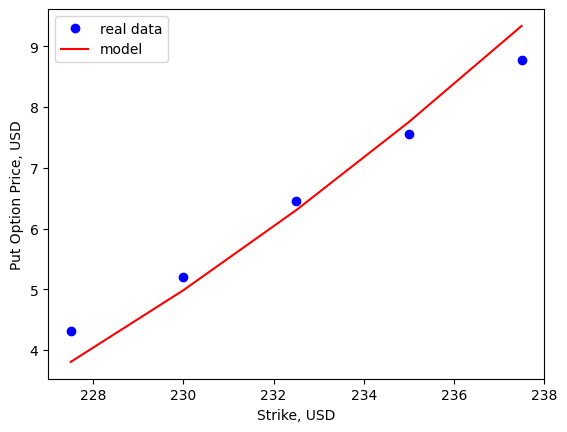

In [ ]:
model_prices = [CM_Heston_opt(S0, put_options_15_dtm['Strike'][i], put_options_15_dtm['T'][i], put_options_15_dtm['r'][i], *params_put_15_cm, 'P') for i in range(len(put_options_15_dtm))]
put_options_15_dtm['model_prices'] = model_prices
y1 = put_options_15_dtm['Price']
y2 = put_options_15_dtm['model_prices']
x = put_options_15_dtm['Strike']
plt.plot(x,y1, 'bo', label = "real data")
plt.plot(x,y2, color='red',label = "model")
plt.xlabel('Strike, USD')
plt.ylabel('Put Option Price, USD')
plt.legend()
plt.show()

# Step 2